In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [2]:
# Function to convert money string to integer
def money_str_int(str):
    number = int(str.strip('$').replace(',',''))
    return number

In [3]:
#New Data

def get_table(soup):
    headers = [col.text.strip() for col in soup.findAll('th')] # column names
    headers.append('URL')
    rows = soup.findAll('table')[0].findAll('tr') # retrieve rows
    data = []
    base_url = 'https://www.boxofficemojo.com'

    # Format table data
    for row in rows[1:]:
        # Get list of text displayed on web page
        cell_data = row.findAll('td')
        cells = [cell.text for cell in cell_data] 
        cells[2] = money_str_int(cells[2])

        # Get URL for each movie and append to list
        movie_url = base_url + row.find('a').attrs['href']
        cells.append(movie_url)

        # Add list to data
        data.append(cells)
        
    return pd.DataFrame(data, columns = headers) #return a data frame

In [4]:
url = 'https://www.boxofficemojo.com/chart/top_lifetime_gross/'
base_url = 'https://www.boxofficemojo.com'
df_movie = pd.DataFrame() 

# Get HTML data for top 1000 grossing movies from Box Office Mojo
for i in range(5):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    fetched_data = get_table(soup)
    if i < 4:
        url = base_url + soup.findAll('li', class_='a-last')[0].find('a').attrs["href"]
    df_movie = df_movie.append(fetched_data, ignore_index = True)
    
df_movie.head()

,Rank,Title,Lifetime Gross,Year,URL
0,1,Star Wars: Episode VII - The Force Awakens,936662225,2015,https://www.boxofficemojo.com/title/tt2488496/...
1,2,Avengers: Endgame,858373000,2019,https://www.boxofficemojo.com/title/tt4154796/...
2,3,Avatar,760507625,2009,https://www.boxofficemojo.com/title/tt0499549/...
3,4,Black Panther,700426566,2018,https://www.boxofficemojo.com/title/tt1825683/...
4,5,Avengers: Infinity War,678815482,2018,https://www.boxofficemojo.com/title/tt4154756/...


In [5]:
# Iterate through above dataframe and pull data from each movie's page
def get_movie_data(url):
    movie_page = requests.get(url)
    movie = BeautifulSoup(movie_page.content, 'html.parser')
    divs = movie.findAll('div', class_='a-section a-spacing-none') #first section of table stored as divs instead of table

    # Variables will come back as 'No Data' if the webpage doesn't have this information
    distributor = 'No Data'
    budget = 'No Data'
    rating = 'No Data'
    duration = 'No Data'
    genres = 'No Data'

    for div in divs:
        spans = div.findAll('span')
        i=0
        for span in spans:      
            if span.text  == 'Domestic Distributor':
                distributor = spans[i+1].text.replace('See full company information\n\n','') #remove extra link text from end
                i+=1
                break
            if span.text == 'Budget':
                budget = money_str_int(spans[i+1].text) #convert budget string to integer
                i+=1
                break
            if span.text == 'MPAA':
                rating = spans[i+1].text
                i+=1
                break
            if span.text == 'Running Time':
                dur = spans[i+1].text.split() #imports duration as hours and minutes
                if len(dur) == 2:
                    dur.extend(['0','0'])
                duration = round( (float(dur[0]) + float(dur[2])/60) , 2) #converts to hours rounded to hundreths
                i+=1
                break
            if span.text == 'Genres':
                genres = spans[i+1].text.replace(' ','').replace('\n\n',',') #.strip wasn't working for some reason
                i+=1
                break
            else:
                i+=1
            
    df_movie = pd.DataFrame([distributor, budget, rating, duration, genres]).transpose()
    df_movie.columns = ['Distributor', 'Budget', 'Rating', 'Running_Time_hrs', 'Genres']

    return df_movie

In [6]:
# loop to get data from first 500 URLs from prior dataframe (broke this up due to timeout issues
df_movie_2 = pd.DataFrame(columns = ['Distributor', 'Budget', 'Rating', 'Running_Time_hrs', 'Genres'])
for url in df_movie['URL'][:500]:
    movie_data = get_movie_data(url)
    df_movie_2 = df_movie_2.append(movie_data, ignore_index=True)
df_movie_2

KeyboardInterrupt: 

In [ ]:
# loop to add data from last 500 URLs from prior dataframe
for url in df_movie['URL'][500:]:
    movie_data = get_movie_data(url)
    df_movie_2 = df_movie_2.append(movie_data, ignore_index=True)

In [ ]:
df_movie_2.columns = ['Distributor', 'Budget', 'Rating', 'Running_Time_hrs', 'Genres']
result = pd.concat([df_movie, df_movie_2], axis=1, join='inner')
result.to_pickle('cats_bomojo_data.pkl')

In [7]:
# RUN THIS CODE TO LOAD CAT'S DATA
df_movie_3 = pd.read_pickle('cats_bomojo_data.pkl')
df_movie_3.head()

,Rank,Title,Lifetime Gross,Year,URL,Distributor,Budget,Rating,Running_Time_hrs,Genres
0,1,Star Wars: Episode VII - The Force Awakens,936662225,2015,https://www.boxofficemojo.com/title/tt2488496/...,Walt Disney Studios Motion Pictures,245000000,PG-13,2.3,"Action,Adventure,Sci-Fi"
1,2,Avengers: Endgame,858373000,2019,https://www.boxofficemojo.com/title/tt4154796/...,Walt Disney Studios Motion Pictures,356000000,PG-13,3.02,"Action,Adventure,Drama,Sci-Fi"
2,3,Avatar,760507625,2009,https://www.boxofficemojo.com/title/tt0499549/...,Twentieth Century Fox,237000000,PG-13,2.7,"Action,Adventure,Fantasy,Sci-Fi"
3,4,Black Panther,700426566,2018,https://www.boxofficemojo.com/title/tt1825683/...,Walt Disney Studios Motion Pictures,No Data,PG-13,2.23,"Action,Adventure,Sci-Fi"
4,5,Avengers: Infinity War,678815482,2018,https://www.boxofficemojo.com/title/tt4154756/...,Walt Disney Studios Motion Pictures,No Data,PG-13,2.48,"Action,Adventure,Sci-Fi"


In [8]:
# function to get unique values 
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print(x)
#get list of unique distributors
unique(df_movie_3['Distributor'])

Walt Disney Studios Motion Pictures
Twentieth Century Fox
Paramount Pictures
Universal Pictures
Warner Bros.
DreamWorks Distribution
Lionsgate
Sony Pictures Entertainment (SPE)
DreamWorks
New Line Cinema
Newmarket Films
Summit Entertainment
Columbia Pictures
IFC Films
TriStar Pictures
Metro-Goldwyn-Mayer (MGM)
Orion Pictures
No Data
Miramax
The Weinstein Company
Fox Searchlight Pictures
Revolution Studios
Artisan Entertainment
Sony Pictures Classics
United Artists
Screen Gems
USA Films
STX Entertainment
Dimension Films
AVCO Embassy Pictures
RKO Radio Pictures
United Artists Releasing
FilmDistrict
Focus Features
IMAX
MacGillivray Freeman Films
American International Pictures (AIP)
Relativity Media
Roadside Attractions


In [9]:
#trim list to top five distributors
dist_data = df_movie_3['Distributor'].isin(['Twentieth Century Fox', 'Sony Pictures Entertainment (SPE)', 
                                       'Universal Pictures', 'Warner Bros.', 'Paramount Pictures'])
top_distributors = object
top_distributors = df_movie_3[dist_data]
top_distributors

,Rank,Title,Lifetime Gross,Year,URL,Distributor,Budget,Rating,Running_Time_hrs,Genres
2,3,Avatar,760507625,2009,https://www.boxofficemojo.com/title/tt0499549/...,Twentieth Century Fox,237000000,PG-13,2.7,"Action,Adventure,Fantasy,Sci-Fi"
5,6,Titanic,659363944,1997,https://www.boxofficemojo.com/title/tt0120338/...,Paramount Pictures,200000000,PG-13,3.23,"Drama,Romance"
6,7,Jurassic World,652270625,2015,https://www.boxofficemojo.com/title/tt0369610/...,Universal Pictures,150000000,PG-13,2.07,"Action,Adventure,Sci-Fi"
11,12,The Dark Knight,535234033,2008,https://www.boxofficemojo.com/title/tt0468569/...,Warner Bros.,185000000,PG-13,2.53,"Action,Crime,Drama,Thriller"
17,18,Star Wars: Episode I - The Phantom Menace,474544677,1999,https://www.boxofficemojo.com/title/tt0120915/...,Twentieth Century Fox,115000000,PG,2.27,"Action,Adventure,Fantasy,Sci-Fi"
...,...,...,...,...,...,...,...,...,...,...
993,994,Jack Reacher,80070736,2012,https://www.boxofficemojo.com/title/tt0790724/...,Paramount Pictures,60000000,PG-13,2.17,"Action,Thriller"
994,995,Cloverfield,80048433,2008,https://www.boxofficemojo.com/title/tt1060277/...,Paramount Pictures,25000000,PG-13,1.42,"Action,Horror,Sci-Fi,Thriller"
995,996,Footloose,80035402,1984,https://www.boxofficemojo.com/title/tt0087277/...,Paramount Pictures,8200000,No Data,1.78,"Drama,Music,Romance"
997,998,Men in Black: International,80001807,2019,https://www.boxofficemojo.com/title/tt2283336/...,Sony Pictures Entertainment (SPE),110000000,PG-13,1.9,"Action,Adventure,Comedy,Sci-Fi"


C:\Users\daveb\anaconda3\envs\learn-env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

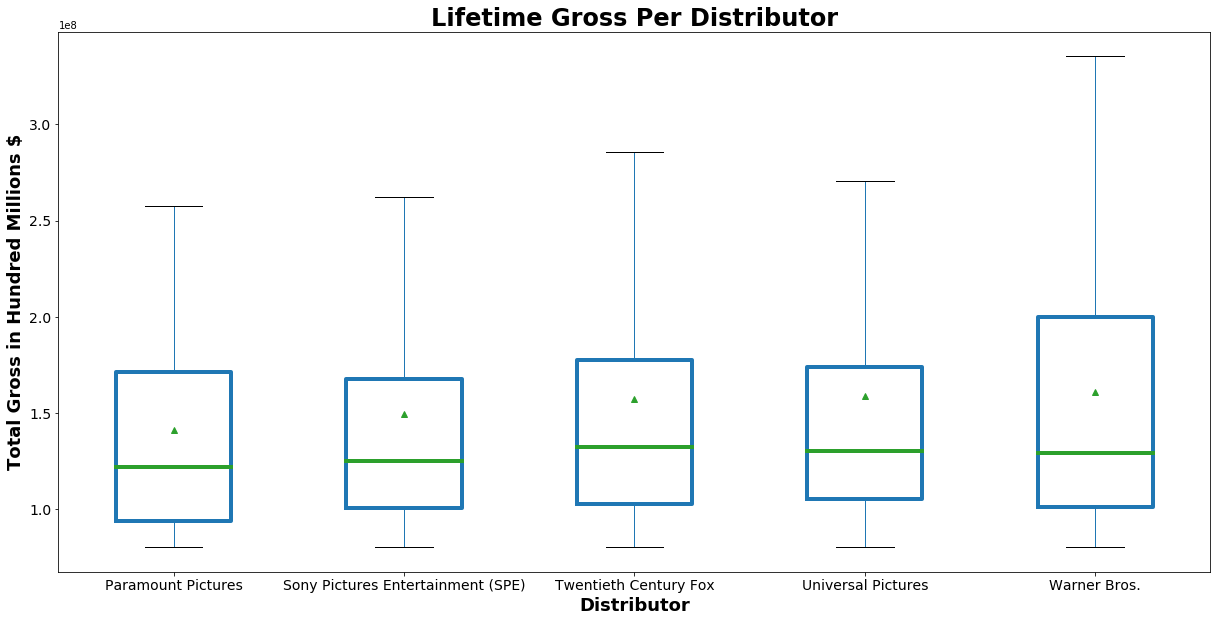

In [10]:
#import necessary libraries
import matplotlib.pyplot as plt  

#format and label the plot
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

bp = top_distributors.boxplot(by ='Distributor', column =['Lifetime Gross'], grid = False, figsize=(20,10),
                         showfliers=False, showmeans=True, boxprops=boxprops, medianprops=medianprops)
bp.set_xlabel('Distributor', fontweight='bold', fontsize=18)
bp.set_ylabel('Total Gross in Hundred Millions $', fontweight='bold', fontsize=18)
bp.set_title('Lifetime Gross Per Distributor', fontweight='bold', fontsize=24)
bp.tick_params(axis='y', labelsize=14)
bp.tick_params(axis='x', labelsize=14)

#show the plot
plt.savefig('images/lifetime_gross_per_distributor.png', dpi=300)
plt.suptitle("")

In [11]:
#get mean, median, Q1, Q3 and IQR for each distributor

In [12]:
paramount_df = top_distributors.loc[top_distributors['Distributor'] == 'Paramount Pictures']
para_mean = paramount_df['Lifetime Gross'].mean()
para_median = paramount_df['Lifetime Gross'].median()
para_q1 = paramount_df['Lifetime Gross'].quantile(.25)
para_q3 = paramount_df['Lifetime Gross'].quantile(.75)
para_iqr = para_q3 - para_q1
print(para_mean)
print(para_median)
print(para_q1)
print(para_q3)
print(para_iqr)

141254524.95726496
121697323.0
93617009.0
171243005.0
77625996.0


In [13]:
sony_df = top_distributors.loc[top_distributors['Distributor'] == 'Sony Pictures Entertainment (SPE)']
sony_mean = sony_df['Lifetime Gross'].mean()
sony_median = sony_df['Lifetime Gross'].median()
sony_q1 = sony_df['Lifetime Gross'].quantile(.25)
sony_q3 = sony_df['Lifetime Gross'].quantile(.75)
sony_iqr = sony_q3 - sony_q1
print(sony_mean)
print(sony_median)
print(sony_q1)
print(sony_q3)
print(sony_iqr)

149112273.0
124799506.5
100424808.75
167724618.75
67299810.0


In [14]:
fox_df = top_distributors.loc[top_distributors['Distributor'] == 'Twentieth Century Fox']
fox_mean = fox_df['Lifetime Gross'].mean()
fox_median = fox_df['Lifetime Gross'].median()
fox_q1 = fox_df['Lifetime Gross'].quantile(.25)
fox_q3 = fox_df['Lifetime Gross'].quantile(.75)
fox_iqr = fox_q3 - fox_q1
print(fox_mean)
print(fox_median)
print(fox_q1)
print(fox_q3)
print(fox_iqr)

157176453.81538463
132314889.0
102338632.25
177359062.75
75020430.5


In [15]:
uni_df = top_distributors.loc[top_distributors['Distributor'] == 'Universal Pictures']
uni_mean = uni_df['Lifetime Gross'].mean()
uni_median = uni_df['Lifetime Gross'].median()
uni_q1 = uni_df['Lifetime Gross'].quantile(.25)
uni_q3 = uni_df['Lifetime Gross'].quantile(.75)
uni_iqr = uni_q3 - fox_q1
print(uni_mean)
print(uni_median)
print(uni_q1)
print(uni_q3)
print(uni_iqr)

158504266.1968504
130164645.0
105083630.0
173897434.0
71558801.75


In [16]:
warner_df = top_distributors.loc[top_distributors['Distributor'] == 'Warner Bros.']
warner_mean = warner_df['Lifetime Gross'].mean()
warner_median = warner_df['Lifetime Gross'].median()
warner_q1 = warner_df['Lifetime Gross'].quantile(.25)
warner_q3 = warner_df['Lifetime Gross'].quantile(.75)
warner_iqr = warner_q3 - warner_q1
print(warner_mean)
print(warner_median)
print(warner_q1)
print(warner_q3)
print(warner_iqr)

160660839.01807228
128880039.5
100947305.0
199560973.25
98613668.25
